In [7]:
import numpy as np
from scipy.integrate import odeint


def make_var_stationary(beta, radius=0.97):
    '''Rescale coefficients of VAR model to make stable.'''
    p = beta.shape[0]
    lag = beta.shape[1] // p
    bottom = np.hstack((np.eye(p * (lag - 1)), np.zeros((p * (lag - 1), p))))
    beta_tilde = np.vstack((beta, bottom))
    eigvals = np.linalg.eigvals(beta_tilde)
    max_eig = max(np.abs(eigvals))
    nonstationary = max_eig > radius
    if nonstationary:
        return make_var_stationary(0.95 * beta, radius)
    else:
        return beta


def simulate_var(p, T, lag, sparsity=0.2, beta_value=1.0, sd=0.1, seed=0):
    if seed is not None:
        np.random.seed(seed)

    # Set up coefficients and Granger causality ground truth.
    GC = np.eye(p, dtype=int)  # 生成一个对角线矩阵，对角线是1，其余全0．
    beta = np.eye(p) * beta_value  # 生成对角线为beta_value,其余为0的p阶方阵.

    num_nonzero = int(p * sparsity) - 1  # 非零个数为p×sparsity-1
    for i in range(p):  # 进行p个循环.
        choice = np.random.choice(p - 1, size=num_nonzero, replace=False)
        choice[choice >= i] += 1
        beta[i, choice] = beta_value
        GC[i, choice] = 1

    beta = np.hstack([beta for _ in range(lag)])
    beta = make_var_stationary(beta)

    # Generate data.
    burn_in = 100
    errors = np.random.normal(scale=sd, size=(p, T + burn_in))
    X = np.zeros((p, T + burn_in))
    X[:, :lag] = errors[:, :lag]
    for t in range(lag, T + burn_in):
        X[:, t] = np.dot(beta, X[:, (t-lag):t].flatten(order='F'))
        X[:, t] += + errors[:, t-1]

    return X.T[burn_in:], beta, GC


def lorenz(x, t, F):
    '''Partial derivatives for Lorenz-96 ODE.'''
    p = len(x)
    dxdt = np.zeros(p)
    for i in range(p):
        dxdt[i] = (x[(i+1) % p] - x[(i-2) % p]) * x[(i-1) % p] - x[i] + F

    return dxdt


def simulate_lorenz_96(p, T, F=10.0, delta_t=0.1, sd=0.1, burn_in=1000,
                       seed=0):
    if seed is not None:
        np.random.seed(seed)

    # Use scipy to solve ODE.
    x0 = np.random.normal(scale=0.01, size=p)
    t = np.linspace(0, (T + burn_in) * delta_t, T + burn_in)
    X = odeint(lorenz, x0, t, args=(F,))
    X += np.random.normal(scale=sd, size=(T + burn_in, p))

    # Set up Granger causality ground truth.
    GC = np.zeros((p, p), dtype=int)
    for i in range(p):
        GC[i, i] = 1
        GC[i, (i + 1) % p] = 1
        GC[i, (i - 1) % p] = 1
        GC[i, (i - 2) % p] = 1

    return X[burn_in:], GC


Analyzing VAR data with T=200


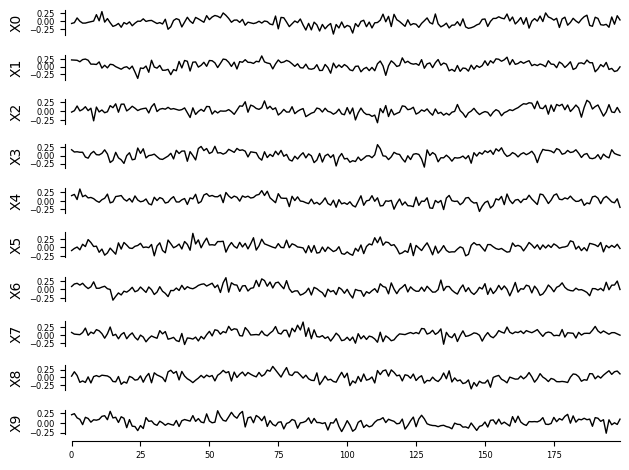


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 5
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1


## Resulting lagged parent (super)sets:

    Variable X0 has 5 link(s):
        (X5 -3): max_pval = 0.01171, |min_val| =  0.185
        (X3 -3): max_pval = 0.01355, |min_val| =  0.181
        (X0 -2): max_pval = 0.01779, |min_val| =  0.174
        (X5 -1): max_pval = 0.02830, |min_val| =  0.160
        (X5 -2): max_pval = 0.03125, |min_val| =  0.158

    Variable X1 has 5 link(s):
        (X3 -1): max_pval = 0.00301, |min_val| =  0.216
        (X1 -1): max_pval = 0.01615, |min_val| =  0.177
        (X3 -3): max_pval = 0.01807, |min_val| =  0.174
        (X1 -3): max_pval = 0.02240, |min_val| =  0.168
        (X3 -5): max_pval = 0.04759, |min_val| =  0.146

    Variable X2 has 3 link(s):
        (X2 -4): max_pval = 0.00173, |min_val| =  0.228
        (X2 -1): max_pval = 0.01110, |min_val| =  0.185


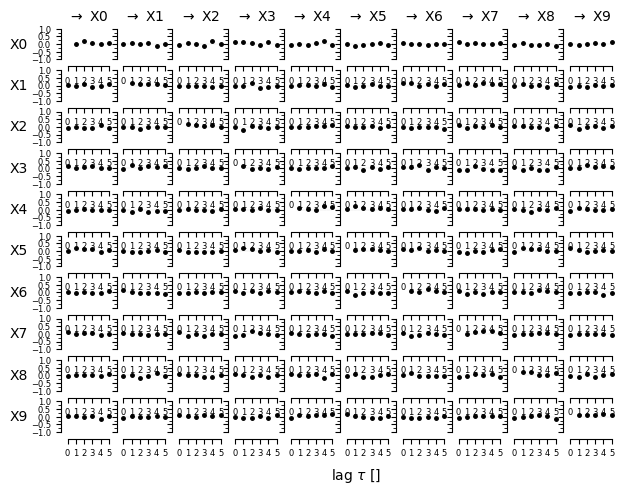

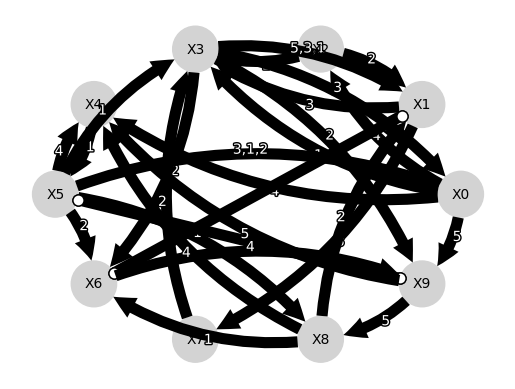

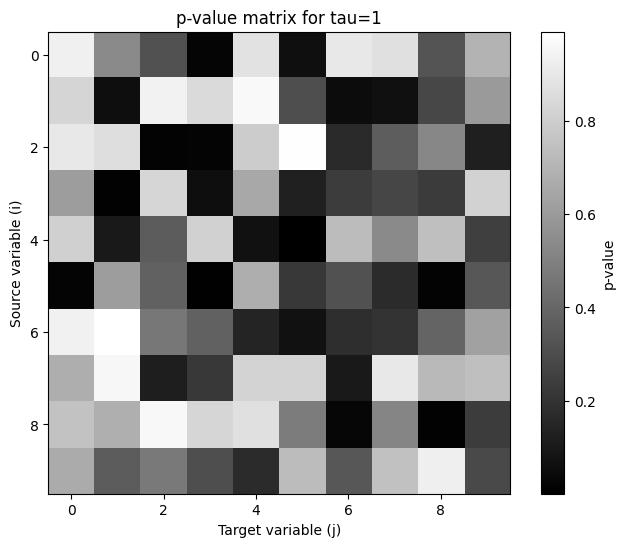

Analyzing Lorenz-96 data with T=200


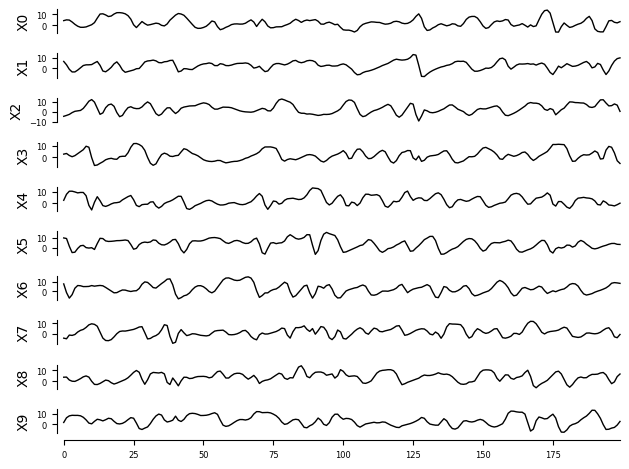


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 5
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1


## Resulting lagged parent (super)sets:

    Variable X0 has 5 link(s):
        (X0 -1): max_pval = 0.00000, |min_val| =  0.845
        (X0 -2): max_pval = 0.00000, |min_val| =  0.521
        (X0 -3): max_pval = 0.00124, |min_val| =  0.233
        (X8 -1): max_pval = 0.00348, |min_val| =  0.212
        (X1 -1): max_pval = 0.00977, |min_val| =  0.188

    Variable X1 has 4 link(s):
        (X1 -1): max_pval = 0.00000, |min_val| =  0.839
        (X1 -2): max_pval = 0.00000, |min_val| =  0.508
        (X8 -3): max_pval = 0.00127, |min_val| =  0.233
        (X1 -3): max_pval = 0.00142, |min_val| =  0.230

    Variable X2 has 4 link(s):
        (X2 -1): max_pval = 0.00000, |min_val| =  0.841
        (X2 -2): max_pval = 0.00000, |min_val| =  0.507
        (X3 -1): max_pval = 0.00276, |min_val| =  0.216


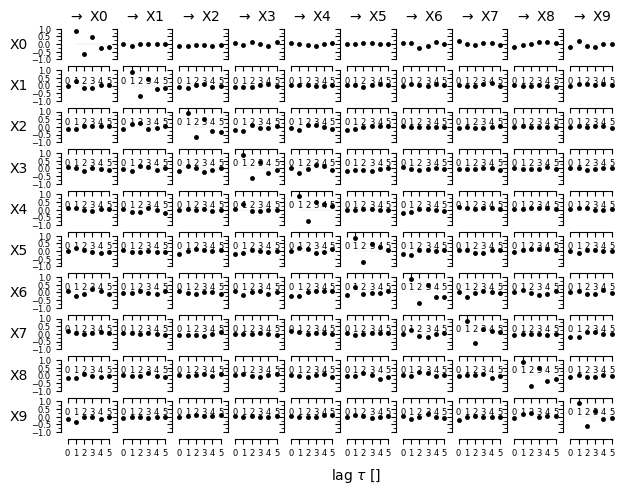

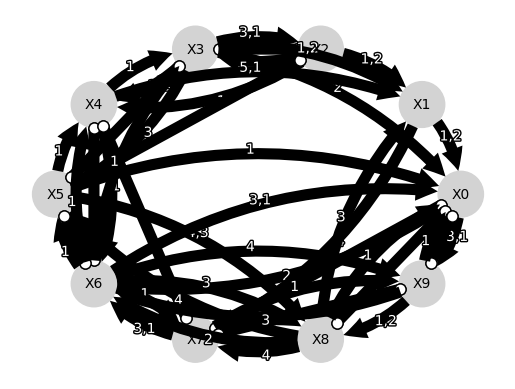

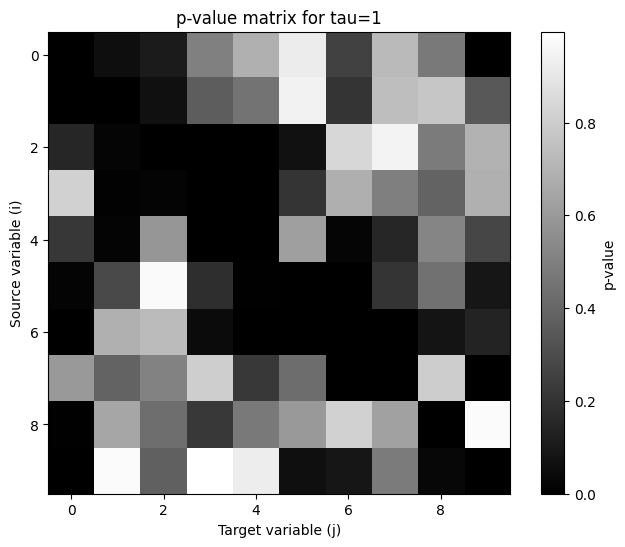

Analyzing VAR data with T=500


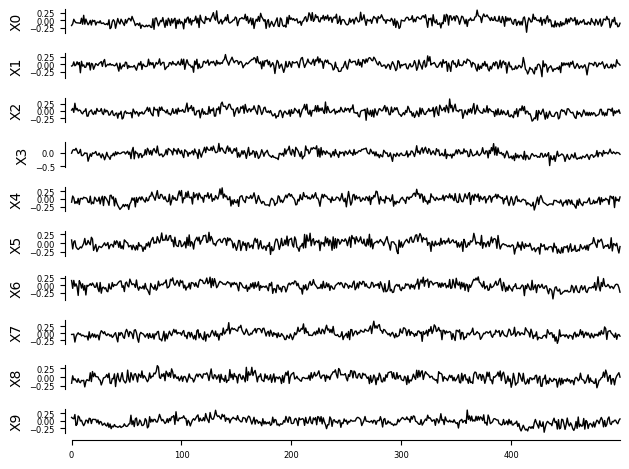


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 5
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1


## Resulting lagged parent (super)sets:

    Variable X0 has 6 link(s):
        (X0 -3): max_pval = 0.00042, |min_val| =  0.160
        (X0 -2): max_pval = 0.00106, |min_val| =  0.148
        (X7 -4): max_pval = 0.00982, |min_val| =  0.117
        (X5 -4): max_pval = 0.03228, |min_val| =  0.097
        (X0 -5): max_pval = 0.04722, |min_val| =  0.090
        (X0 -1): max_pval = 0.04897, |min_val| =  0.090

    Variable X1 has 6 link(s):
        (X1 -1): max_pval = 0.00003, |min_val| =  0.189
        (X3 -4): max_pval = 0.00047, |min_val| =  0.158
        (X3 -2): max_pval = 0.00155, |min_val| =  0.143
        (X3 -3): max_pval = 0.01011, |min_val| =  0.117
        (X1 -4): max_pval = 0.01055, |min_val| =  0.116
        (X1 -5): max_pval = 0.01285, |min_val| =  0.113

    Variable X2 has 7 link(s):


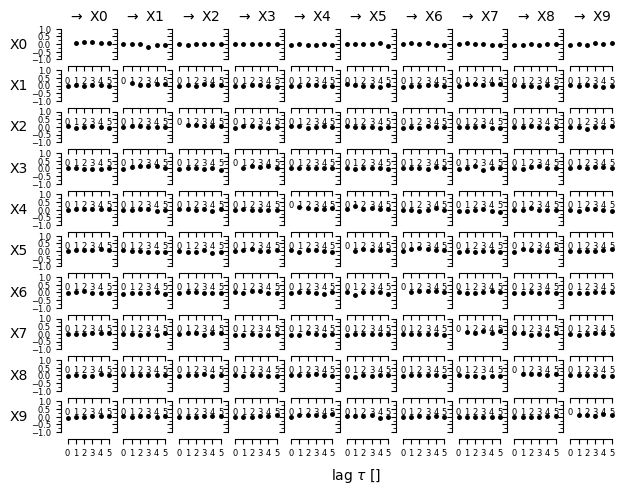

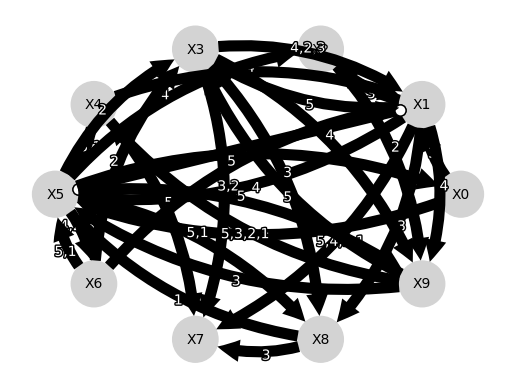

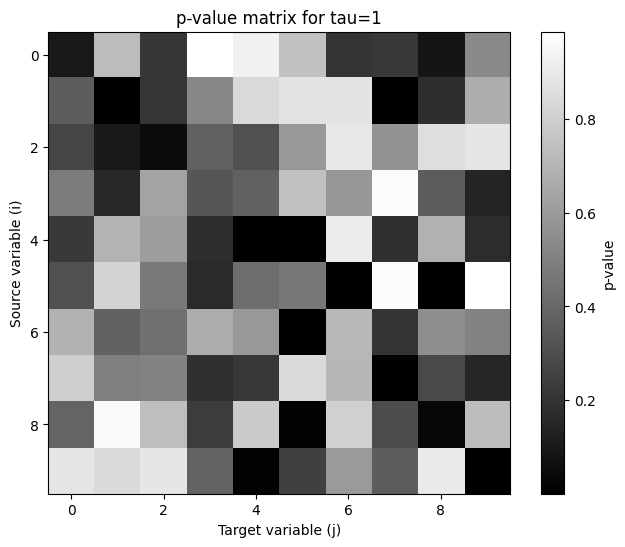

Analyzing Lorenz-96 data with T=500


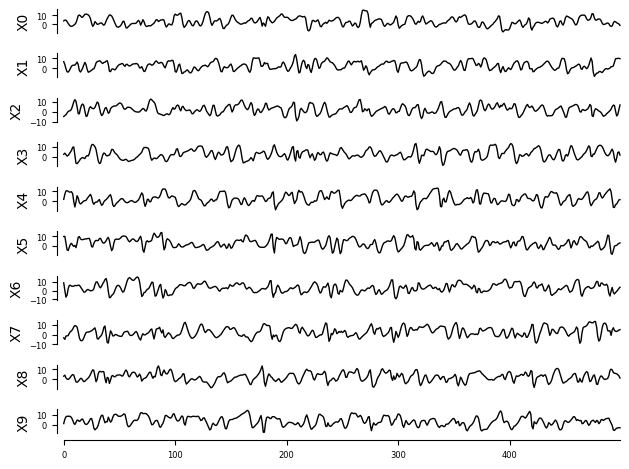


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 5
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1


## Resulting lagged parent (super)sets:

    Variable X0 has 5 link(s):
        (X0 -1): max_pval = 0.00000, |min_val| =  0.859
        (X0 -2): max_pval = 0.00000, |min_val| =  0.582
        (X0 -3): max_pval = 0.00000, |min_val| =  0.324
        (X8 -1): max_pval = 0.00000, |min_val| =  0.234
        (X0 -4): max_pval = 0.00102, |min_val| =  0.148

    Variable X1 has 6 link(s):
        (X1 -1): max_pval = 0.00000, |min_val| =  0.849
        (X1 -2): max_pval = 0.00000, |min_val| =  0.537
        (X1 -3): max_pval = 0.00000, |min_val| =  0.268
        (X2 -1): max_pval = 0.00001, |min_val| =  0.203
        (X9 -1): max_pval = 0.00445, |min_val| =  0.129
        (X1 -4): max_pval = 0.01286, |min_val| =  0.112

    Variable X2 has 6 link(s):
        (X2 -1): max_pval = 0.00000, |min_val| =  0.827


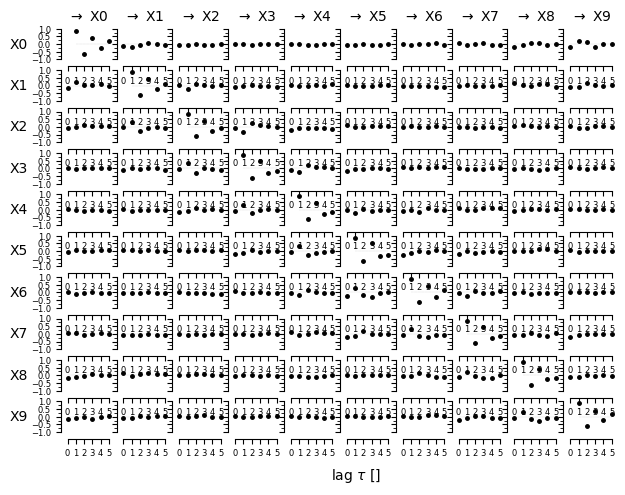

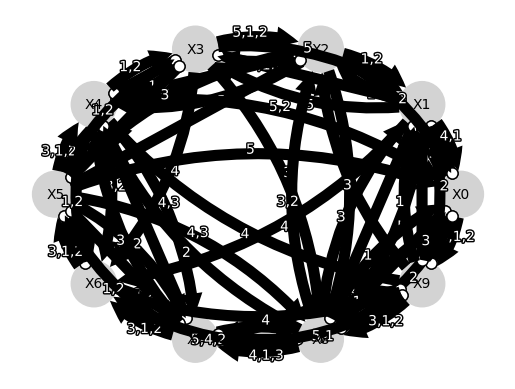

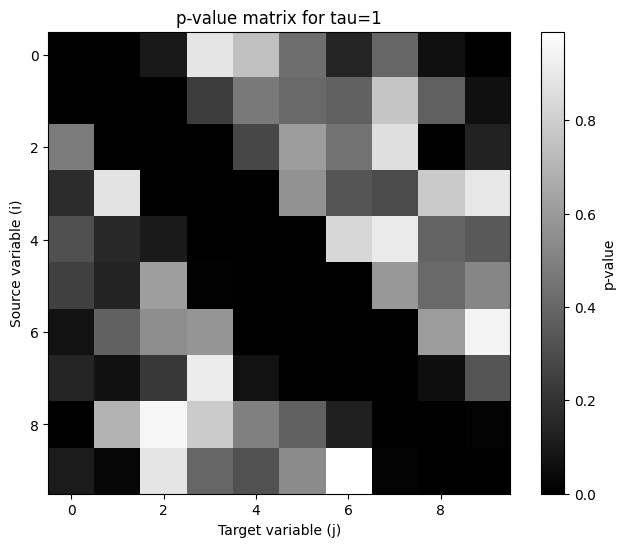

Analyzing VAR data with T=1000


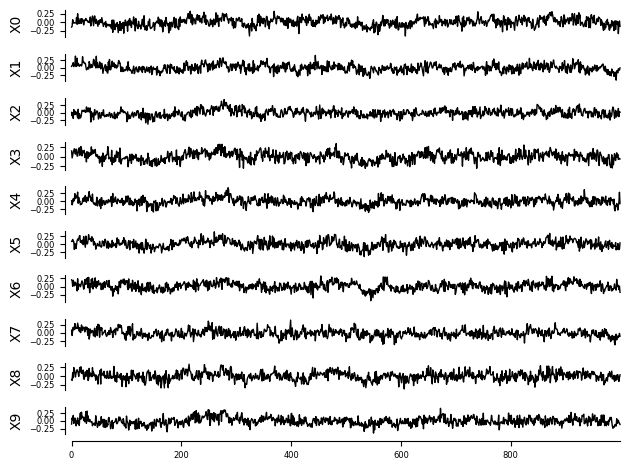


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 5
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1


## Resulting lagged parent (super)sets:

    Variable X0 has 10 link(s):
        (X0 -1): max_pval = 0.00023, |min_val| =  0.117
        (X5 -3): max_pval = 0.00035, |min_val| =  0.114
        (X0 -3): max_pval = 0.00079, |min_val| =  0.107
        (X5 -1): max_pval = 0.00209, |min_val| =  0.098
        (X0 -5): max_pval = 0.00214, |min_val| =  0.098
        (X5 -5): max_pval = 0.00363, |min_val| =  0.093
        (X0 -2): max_pval = 0.00464, |min_val| =  0.090
        (X0 -4): max_pval = 0.00553, |min_val| =  0.089
        (X5 -2): max_pval = 0.00650, |min_val| =  0.087
        (X3 -3): max_pval = 0.02527, |min_val| =  0.071

    Variable X1 has 9 link(s):
        (X1 -2): max_pval = 0.00002, |min_val| =  0.134
        (X1 -1): max_pval = 0.00026, |min_val| =  0.116
        (X3 -4): max_pval = 0.0

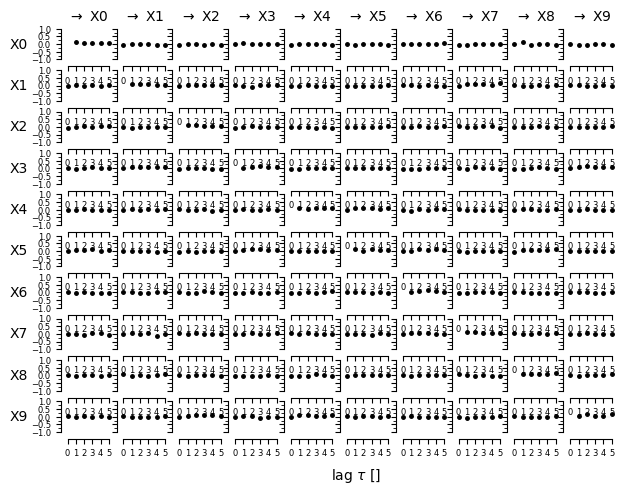

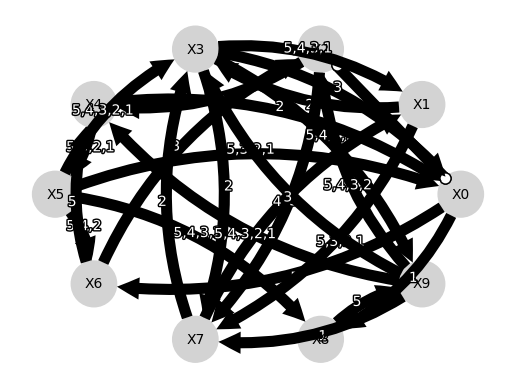

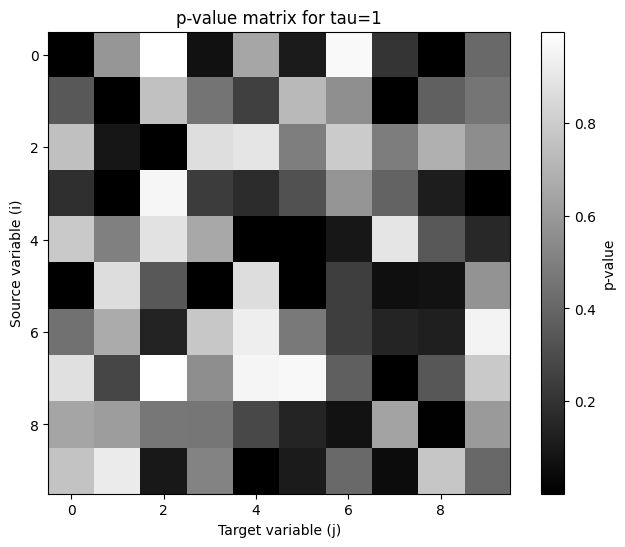

Analyzing Lorenz-96 data with T=1000


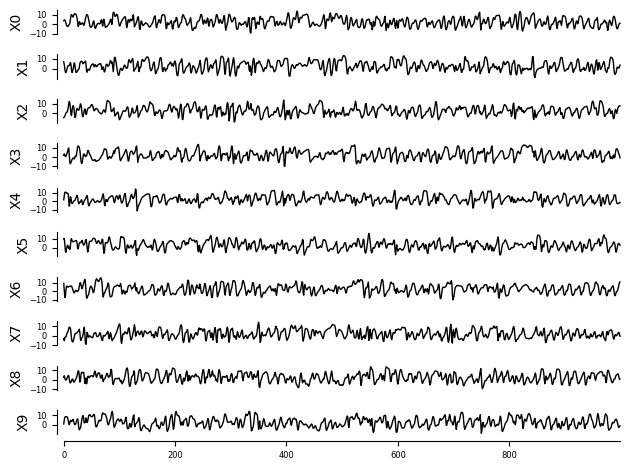


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 5
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1


## Resulting lagged parent (super)sets:

    Variable X0 has 7 link(s):
        (X0 -1): max_pval = 0.00000, |min_val| =  0.823
        (X0 -2): max_pval = 0.00000, |min_val| =  0.458
        (X1 -1): max_pval = 0.00000, |min_val| =  0.172
        (X0 -3): max_pval = 0.00000, |min_val| =  0.153
        (X8 -1): max_pval = 0.00001, |min_val| =  0.141
        (X7 -5): max_pval = 0.00147, |min_val| =  0.101
        (X0 -5): max_pval = 0.01353, |min_val| =  0.078

    Variable X1 has 8 link(s):
        (X1 -1): max_pval = 0.00000, |min_val| =  0.839
        (X1 -2): max_pval = 0.00000, |min_val| =  0.500
        (X9 -1): max_pval = 0.00000, |min_val| =  0.210
        (X1 -3): max_pval = 0.00000, |min_val| =  0.185
        (X2 -1): max_pval = 0.00000, |min_val| =  0.158
        (X0 -1): max_pval = 0.00

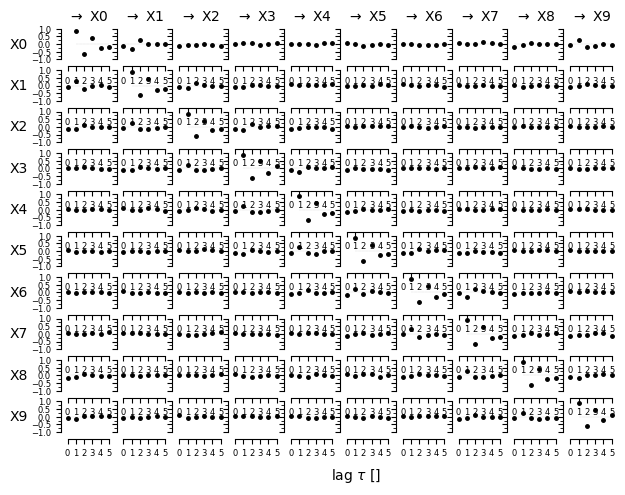

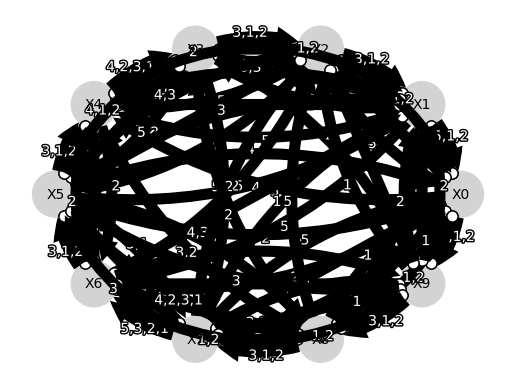

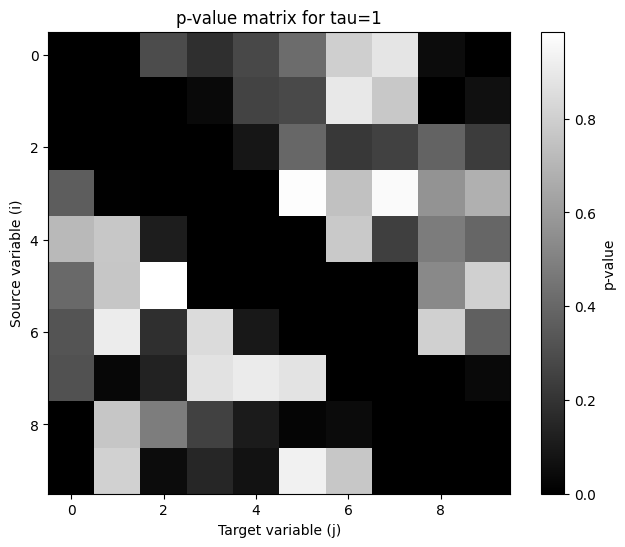

In [8]:
from tigramite.independence_tests.parcorr import ParCorr
import numpy as np
import matplotlib.pyplot as plt
from tigramite import data_processing as pp
from tigramite.pcmci import PCMCI
import tigramite.plotting as tp


# 定义参数
p = 10  # 维度
lengths = [200, 500, 1000]  # 不同的时间序列长度
lag = 5
seed = 981  # 随机种子

# 函数用于生成和分析数据
def analyze_data(X, var_names):
    # 创建 Tigramite 数据框
    dataframe = pp.DataFrame(X, var_names=var_names)

    # 绘制时间序列
    tp.plot_timeseries(dataframe=dataframe)
    plt.show()

    # 初始化部分相关性检验对象
    parcorr = ParCorr(significance='analytic')

    # 初始化 PCMCI 对象
    pcmci = PCMCI(
        dataframe=dataframe,
        cond_ind_test=parcorr,
        verbosity=1
    )

    # 运行 PCMCI 以获取滞后依赖关系
    tau_max = lag  # 设置最大滞后时间
    results = pcmci.run_pcmci(tau_max=tau_max, pc_alpha=0.05)  # 设置显著性水平 (alpha)

    # 绘制滞后相关性矩阵
    tp.plot_lagfuncs(val_matrix=results['val_matrix'], setup_args={'var_names': var_names})
    plt.show()

    # 提取因果图矩阵
    graph = results['graph']

    # 绘制因果图
    tp.plot_graph(
        graph=graph,               # 因果图矩阵
        var_names=var_names,       # 变量名
        link_colorbar_label='MCI', # 链接颜色图例的标签
    )
    plt.show()

    # 提取 p 值矩阵
    p_matrix = results['p_matrix']

    # 设置你希望显示的滞后时间，假设选择第一个滞后时间（tau=1）
    tau_to_plot = 1  # 选择滞后时间 tau = 1

    # 绘制 p 值矩阵的灰度图像
    plt.figure(figsize=(8, 6))
    plt.imshow(p_matrix[:, :, tau_to_plot], cmap='gray', interpolation='none')
    plt.colorbar(label='p-value')
    plt.title(f'p-value matrix for tau={tau_to_plot}')
    plt.xlabel('Target variable (j)')
    plt.ylabel('Source variable (i)')
    plt.show()

# 对于不同的时间序列长度进行分析
for T in lengths:
    # 生成 VAR 数据
    X_var, beta_var, GC_var = simulate_var(p, T, lag, sparsity=0.2, beta_value=1.0, sd=0.1, seed=seed)
    var_names = [f'X{i}' for i in range(p)]
    print(f'Analyzing VAR data with T={T}')
    analyze_data(X_var, var_names)

    # 生成 Lorenz-96 数据
    X_lorenz, GC_lorenz = simulate_lorenz_96(p, T, F=10.0, delta_t=0.1, sd=0.1, burn_in=100, seed=seed)
    print(f'Analyzing Lorenz-96 data with T={T}')
    analyze_data(X_lorenz, var_names)
